# Distributed Computing Inspired by Biology

This notebook showcases the different bio-inspired algorithms discussed in
> Függer, M., Nowak, T., Thuillier, K. (2025). Distributed Computing Inspired by Biology. Seminars in Cell and Developmental Biology.

It requires the *Python 3* packages: `numpy`, `networkx`, `scipy`, `mobspy`, `ipykernel`, and `ipywidgets`.

It can also be executed online (*without any installation*), using *Binder* [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/BioDisCo/dc_bio/HEAD).

In [1]:
import numpy as np

from src.notebook_utils import *  # noqa: F403


## Hodkin-Huxley Neuron Model

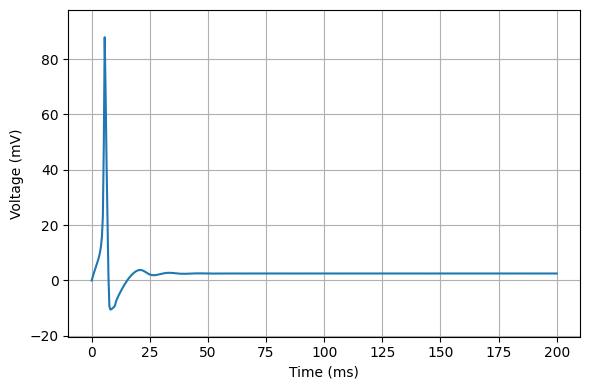

In [2]:
interact_hodgkin_huxley(duration=200, steps=500)  # noqa: F405

## Differentiable Loss Functions: Gradient Descent

In [3]:
def f(x: float, y: float) -> float:  # noqa: D103
    return np.sin(np.pi * x) * np.cos(np.pi * y) + (x**2 + y**2)


def df_dx(x: float, y: float) -> float:  # noqa: D103
    return np.pi * np.cos(np.pi * x) * np.cos(np.pi * y) + 2 * x


def df_dy(x: float, y: float) -> float:  # noqa: D103
    return -np.pi * np.sin(np.pi * x) * np.sin(np.pi * y) + 2 * y

In [4]:
interact_gradient_descent(f, df_dx, df_dy)  # noqa: F405

## General Loss Functions

In [5]:
def f(x: float, y: float) -> float:  # noqa: D103
    return np.sin(np.pi * x) * np.cos(np.pi * y) + (x**2 + y**2)

### Differential Evolution

In [6]:
interact_differential_evolution(f)  # noqa: F405

### Particle Swarm

In [7]:
interact_particle_swarm(f)  # noqa: F405

## Consensus

### Graphs Generation

In [8]:
graphs, sequence = interact_consensus_graphs()  # noqa: F405

### 1D Methods

#### Equal-weight

In [9]:
interact_consensus_1D(sequence, "mean")  # noqa: F405

#### Midpoint

In [10]:
interact_consensus_1D(sequence, "midpoint")  # noqa: F405

### 2D Methods: MidExtreme vs ApproachExtreme

#### MidExtreme

In [11]:
interact_consensus_2D(sequence, "midextreme")  # noqa: F405

#### ApproachExtreme

In [12]:
interact_consensus_2D(sequence, "approachextreme")  # noqa: F405

## Chemical Reaction Networks

### ABC Model

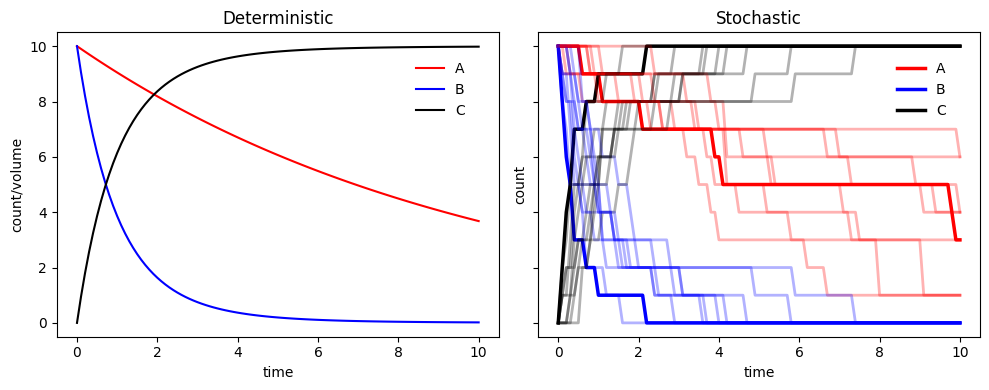

In [13]:
interact_crn_abc(duration=10)  # noqa: F405

### Annihilation Model

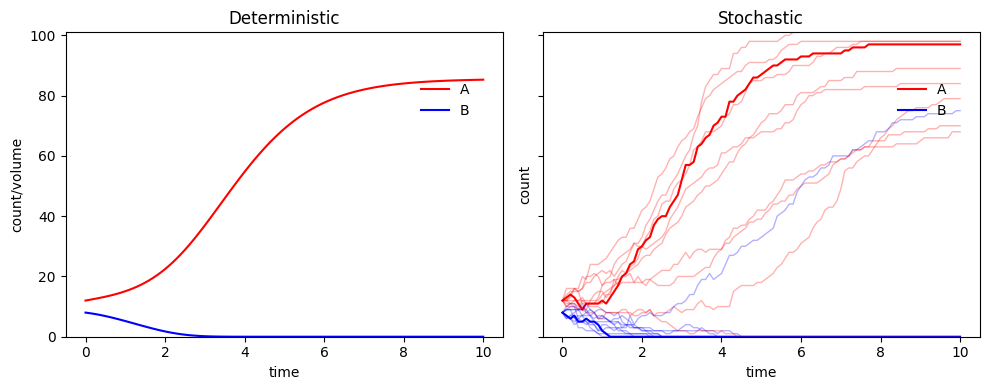

In [14]:
interact_crn_mutual_annihilation(duration=10)  # noqa: F405

## Maximal Independent Set - MIS

In [15]:
interact_maximal_independent_set()  # noqa: F405